# DeepTCN model

There is an example of probabilistic forecasting using TCN model that very close to DeepTCN described in https://arxiv.org/abs/1906.04397

In [1]:
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
import pandas as pd

from darts.models import TCNModel
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihoodModel
from darts.datasets import EnergyDataset
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

import matplotlib.pyplot as plt

## Variable noise series

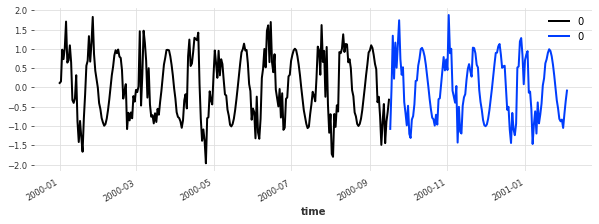

In [3]:
length = 400
trend = tg.linear_timeseries(length=length, end_value=4)
season1 = tg.sine_timeseries(length=length, value_frequency=0.05, value_amplitude=1.0)
noise = tg.gaussian_timeseries(length=length, std=0.6)
noise_modulator = (
    tg.sine_timeseries(length=length, value_frequency=0.02) 
    + tg.constant_timeseries(length=length, value=1)) / 2
noise = noise * noise_modulator

target_series = sum([noise, season1])
covariates = noise_modulator
target_train, target_val = target_series.split_after(0.65)

plt.figure(figsize=(10, 3))
target_train.plot()
target_val.plot()

In [4]:
deeptcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=20,
    kernel_size=2,
    num_filters=4,
    dilation_base=2,
    dropout=0,
    random_state=0,
    likelihood=GaussianLikelihoodModel())

deeptcn.fit(target_train, 
            past_covariates=covariates, 
            verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

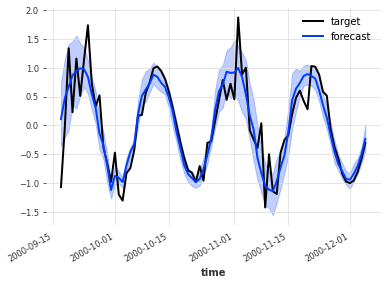

In [6]:
pred = deeptcn.predict(80, past_covariates=covariates, num_samples=100)
target_val.slice_intersect(pred).plot(label='target')
pred.plot(label='forecast')

## Daily energy production

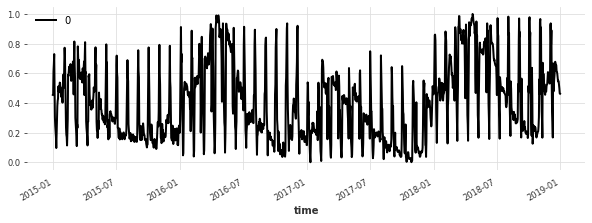

In [7]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
series_en = fill_missing_values(
    TimeSeries.from_dataframe(df3_day_avg, 'time', ['generation hydro run-of-river and poundage']), 'auto')

# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(pd.Timestamp('20170901'))

# add the day as a covariate
day_series = datetime_attribute_timeseries(series_en_transformed, attribute='day', one_hot=True)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp('20170901'))

plt.figure(figsize=(10, 3))
series_en_transformed.plot()

In [8]:
deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=20,
    optimizer_kwargs={'lr': 1e-3}, 
    random_state=0,
    input_chunk_length=300,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=4,
    likelihood=GaussianLikelihoodModel())

deeptcn.fit(series=train_en_transformed, past_covariates=train_day, verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
backtest_en = deeptcn.historical_forecasts(
    series=series_en_transformed,
    past_covariates=day_series,
    num_samples=50,
    start=0.7,
    forecast_horizon=30,
    stride=5,
    retrain=False,
    verbose=True)

  0%|          | 0/83 [00:00<?, ?it/s]

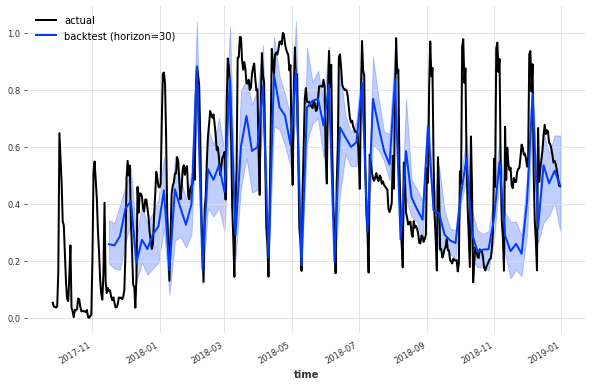

In [10]:
plt.figure(figsize=(10,6))
series_en_transformed[1000:].plot(label='actual')
backtest_en.plot(
    label='backtest (horizon=30)', 
    low_quantile=0.01, 
    high_quantile=0.99)
plt.legend();